# 作業 1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個 CNN 模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**


>**作業說明**

**第一步驟**: 左上角 檔案 -> 在雲端硬碟建立副本。

**第二步驟**: 右上角 共用 -> 取得連結 -> 任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段 -> 更變執行類型 -> GPU。可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個 colab 的程式來完成訓練 CNN 模型。**只要跑得出來 Testing Accuracy、Loss; 1~7 個作業項目即可**，不必一定要照著 todo 提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的 label 不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label 隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看 test data
2. 模型請手刻、手疊，**不要用 Transfer Learning** 來引入 ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存 output 結果，更改**檔名學號**，左上角 檔案 -> 下載 -> 下載.ipynb檔。
2. 交一個 pdf 檔，裡面需要附上**你的作業 colab 連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的 Test Acc
4. 上述兩個檔案繳交至 ee-class。

> **算分標準**

20 + Test_Acc + Predict function(10 分) + 20 分文件
1. 20 分免費送
2. Test_Acc (1 分/1%)
3. predict_author 有寫出來就 10 分(第七段)
4. 20 分是文件分數
    - 姓名、學號、年級
    - colab 連結
    - Test accuracy
    - 撰寫過程與截圖
    - 心得

有問題再來信助教: lexlie.yunglinchu@gmail.com

### 資料集下載

- 資料集說明 : 
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊 colab 左側**檔案**來查看

- 下載連結：
  - train: https://drive.google.com/file/d/1K3FRVeabwV7TxboRsrkFcT34tPV9DWqr/view?usp=sharing
  - test: https://drive.google.com/file/d/1GCzWxFrIbb4d1JSXSrt3kRb6uERVqXpx/view?usp=sharing


In [1]:
import random
import os

# 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# 以節省學術網路資源，避免 IP 被封鎖

if not os.path.isfile("./train.zip"):
    !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
    !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
    !unzip train.zip
    !unzip test.zip
else:
    !echo "檔案已存在"

串流輸出內容已截斷至最後 5000 行。
  inflating: train_resized/Joan_Miro_27.jpg  
  inflating: train_resized/Joan_Miro_28.jpg  
  inflating: train_resized/Joan_Miro_29.jpg  
  inflating: train_resized/Joan_Miro_3.jpg  
  inflating: train_resized/Joan_Miro_30.jpg  
  inflating: train_resized/Joan_Miro_31.jpg  
  inflating: train_resized/Joan_Miro_32.jpg  
  inflating: train_resized/Joan_Miro_33.jpg  
  inflating: train_resized/Joan_Miro_34.jpg  
  inflating: train_resized/Joan_Miro_35.jpg  
  inflating: train_resized/Joan_Miro_36.jpg  
  inflating: train_resized/Joan_Miro_37.jpg  
  inflating: train_resized/Joan_Miro_39.jpg  
  inflating: train_resized/Joan_Miro_4.jpg  
  inflating: train_resized/Joan_Miro_40.jpg  
  inflating: train_resized/Joan_Miro_42.jpg  
  inflating: train_resized/Joan_Miro_43.jpg  
  inflating: train_resized/Joan_Miro_44.jpg  
  inflating: train_resized/Joan_Miro_45.jpg  
  inflating: train_resized/Joan_Miro_46.jpg  
  inflating: train_resized/Joan_Miro_47.jpg  
  inflating: tr

## 1. 讀入封包

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
from keras.layers import BatchNormalization

## 2. 取得資料集

- **我們來檢視一下 artist.csv**，重要內容包含:
  - 畫家名稱 (name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有 50 位畫家，意謂著有 50 個 class 要去辨識。

In [3]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]  #回傳行數
print("Number of artists : ", num_classes)
artists.head()  #前五筆資料

Number of artists :  50


id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: ?а?и?...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod m?n?]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [??ne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

* 只取出名字與畫的數量，把名字用下底線連起來

In [4]:
artists = artists.loc[:, ["name", "paintings"]]  #用index的標籤來取出資料
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

name  paintings
0   Amedeo_Modigliani        193
1  Vasiliy_Kandinskiy         88
2        Diego_Rivera         70
3        Claude_Monet         73
4       Rene_Magritte        194

* **計算各個畫家畫作數量**
* 每個 class 資料的不平衡容易影響模型的訓練，學生可以嘗試解決這個問題。(提示: keras 的 class_weight)

可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


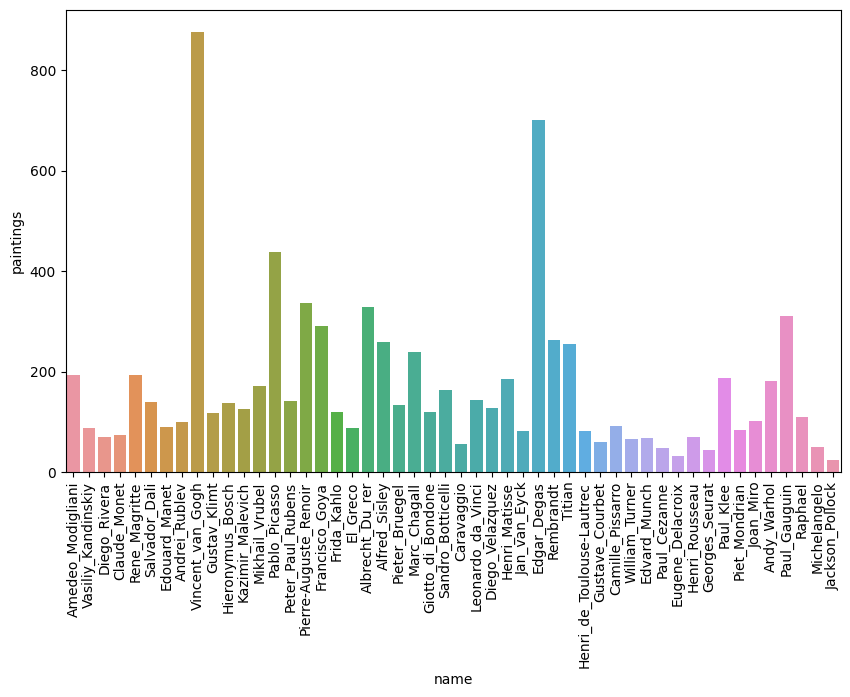

In [5]:
%matplotlib inline
plt.figure(figsize=(10, 6)) #a為圖形的寬， b為圖形的高，單位為英寸
barplot = sns.barplot(x=artists.name, y=artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)

print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ", artists.paintings.max(), " 最少畫作為 : ", artists.paintings.min())

* 隨機讀取畫作來看看

training 畫作總共畫作有 :  7520


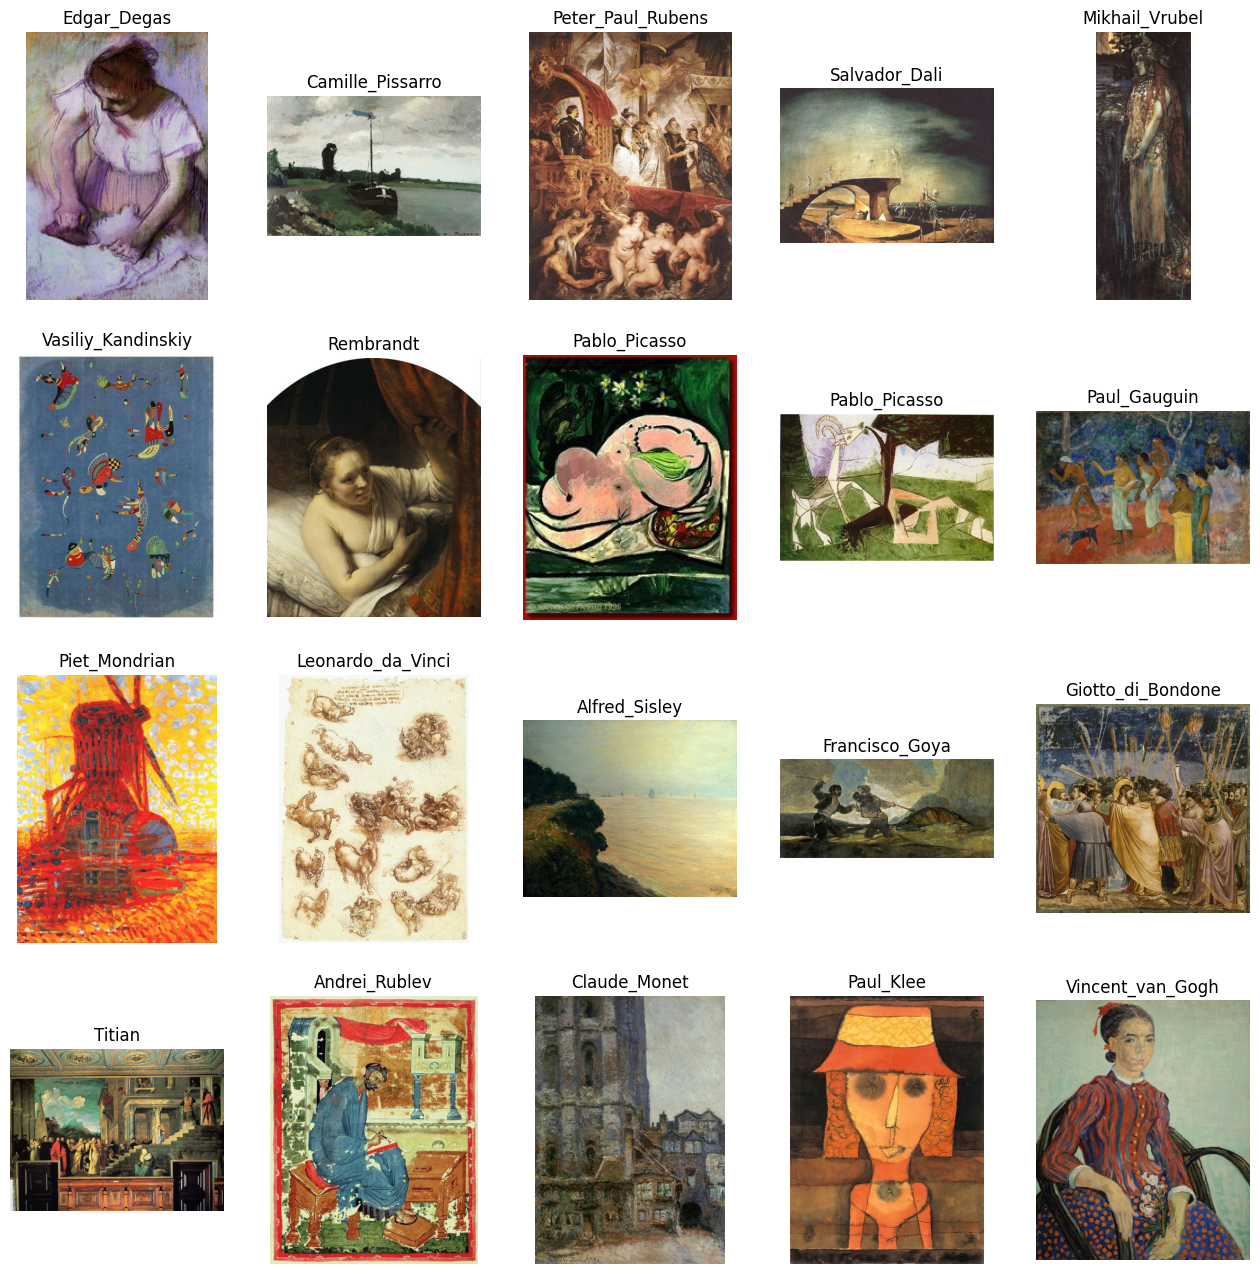

In [6]:
img_list = os.listdir(train_dir) #返回指定的文件夾包含的文件或文件夾的名字的列表
total_len = len(img_list)
random_list = random.sample(range(0, total_len), 20)
print("training 畫作總共畫作有 : ", total_len)

show_imgs = [img_list[rand] for rand in random_list]

plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs): #enumerate() 函式來同時輸出索引與元素
    img_path = train_dir + imgName
    img = cv.imread(img_path) #讀取圖片檔
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) #將影像的色彩模型從將BGR格式轉換成RGB格式 
    plt.subplot(4, 5, index + 1) 
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出 label : Claude_Monet
2. label (作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label 數字還要轉成 50 depth 的 one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到 [0,1] 之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料 input output 的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入 tensor 後用 map 將路徑轉成圖片檔案。

* **以下程式 todo 只是提供程式思路，你完全可以不理他，反正 test 結果能出來就好。**

In [7]:
# 請建立將英文映射成數字的 dict。EX: Van_Gogh --> 0
def make_author_dict():
    ##########
    # todo #
    ##########
    author_dict={}
    artists = pd.read_csv("./artists.csv")
    id_data = list(artists.loc[:, 'id'])
    print(id_data)
    artists.loc[:, 'name']
    name_data = list(artists["name"].str.split(" ").apply(lambda parts: "_".join(parts)))
    print(name_data)
    for i in range(len(id_data)):
      author_dict[name_data[i]]=id_data[i]
    print(author_dict)
    return author_dict



class_name = make_author_dict()
def rev_author_dict():
    ##########
    # todo #
    ##########
    re_author_dict={}
    artists = pd.read_csv("./artists.csv")
    id_data = list(artists.loc[:, 'id'])
    artists.loc[:, 'name']
    name_data = list(artists["name"].str.split(" ").apply(lambda parts: "_".join(parts)))
    for i in range(len(id_data)):
      re_author_dict[id_data[i]]=name_data[i]
    print(re_author_dict)
    return re_author_dict
# 請建立將數字映射成英文的 dict。 EX: 0 --> Van_Gogh
rev_class_name = rev_author_dict()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
['Amedeo_Modigliani', 'Vasiliy_Kandinskiy', 'Diego_Rivera', 'Claude_Monet', 'Rene_Magritte', 'Salvador_Dali', 'Edouard_Manet', 'Andrei_Rublev', 'Vincent_van_Gogh', 'Gustav_Klimt', 'Hieronymus_Bosch', 'Kazimir_Malevich', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Francisco_Goya', 'Frida_Kahlo', 'El_Greco', 'Albrecht_Du_rer', 'Alfred_Sisley', 'Pieter_Bruegel', 'Marc_Chagall', 'Giotto_di_Bondone', 'Sandro_Botticelli', 'Caravaggio', 'Leonardo_da_Vinci', 'Diego_Velazquez', 'Henri_Matisse', 'Jan_van_Eyck', 'Edgar_Degas', 'Rembrandt', 'Titian', 'Henri_de_Toulouse-Lautrec', 'Gustave_Courbet', 'Camille_Pissarro', 'William_Turner', 'Edvard_Munch', 'Paul_Cezanne', 'Eugene_Delacroix', 'Henri_Rousseau', 'Georges_Seurat', 'Paul_Klee', 'Piet_Mondrian', 'Joan_Miro', 'Andy_War

In [8]:
def get_label(pic_name):
    # 請取出 label 並轉成數字
    # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
    ##########
    # todo #
    ##########
    pic_name="_".join(pic_name.split("_")[:-1])
    imgName_label=class_name[pic_name] 
    return imgName_label

#print(get_label("Claude_Monet_1_1.jpg"))

def get_path(dir, pic_name):
    # 請將路徑合併
    # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
    ##########
    # todo #
    ##########
    imgPath=dir + pic_name
    return imgPath
#print(get_path("./train_resized/","Claude_Monet_1.jpg"))

def make_paths_label(dir):
    img_list = os.listdir(dir)
    paths = []
    labels = []
    onehot_labels = []
    # 將preprocess完成的 path、label 用 for 迴圈放入 paths 和 labels
    ##########
    # todo #
    ##########
    for i in range(len(img_list)):
      labels.append(get_label(img_list[i]))
      paths.append(get_path(dir,img_list[i]))
    # 將 labels 轉成 onehot
    # todo
    train_label = keras.utils.to_categorical(labels,num_classes)
    onehot_labels=train_label
    return paths , onehot_labels

#make_paths_label("./train_resized/")

In [9]:
# 來查看一下
np.set_printoptions(threshold=np.inf)

paths, onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
    print(p)
print("-" * 20)
print("labels : ")
for label in onehot_labels[:5]:
    print(label)

paths : 
./train_resized/Sandro_Botticelli_154.jpg
./train_resized/Vincent_van_Gogh_695.jpg
./train_resized/Kazimir_Malevich_45.jpg
./train_resized/Edouard_Manet_86.jpg
./train_resized/Kazimir_Malevich_69.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [10]:
# 轉成 tensorflow dataset 格式，變成路徑 tensor
# 這個只是 from_tensor_slices 範例
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
    print(tensor)

turn to tensor
tf.Tensor(b'./train_resized/Sandro_Botticelli_154.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Vincent_van_Gogh_695.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Kazimir_Malevich_45.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Edouard_Manet_86.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Kazimir_Malevich_69.jpg', shape=(), dtype=string)


In [11]:
# 決定你輸入模型的圖片長寬
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
# shuffle buffer size
SHUFFLE_BUFFER = 1000


def get_image(path):
    # read image from path
    file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(file, channels=3)
    img = tf.cast(img, tf.float32)

    # 請固定每張圖片大小為 IMG_HEIGHT、IMG_WIDTH
    # 並將圖片每個 pixel 映射到 [0,1] 之間
    ##########
    # todo #
    ##########
    # resize the image to IMG_HEIGHT x IMG_WIDTH
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    
    # normalize pixel values to [0, 1]
    img /= 255.0
    return img
#plt.imshow(get_image("./train_resized/Albrecht_Du_rer_3.jpg"))

# 將所有資料轉成 Tensor -> Tensor 轉成圖片
# 圖片 Tensor 與 label Tensor Zip 起來成一個 pair
# shuffle 打散
def make_dataset(dir):
    paths, onehot_labels = make_paths_label(dir)
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

    # 將路徑 tensor 映射成圖片 tensor
    train_image = paths_ds.map(get_image)
    # 合併圖片與 label 資料集
    full_ds = tf.data.Dataset.zip((train_image, train_label))
    # 打散
    full_ds = full_ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)
    return full_ds


full_ds = make_dataset(train_dir)

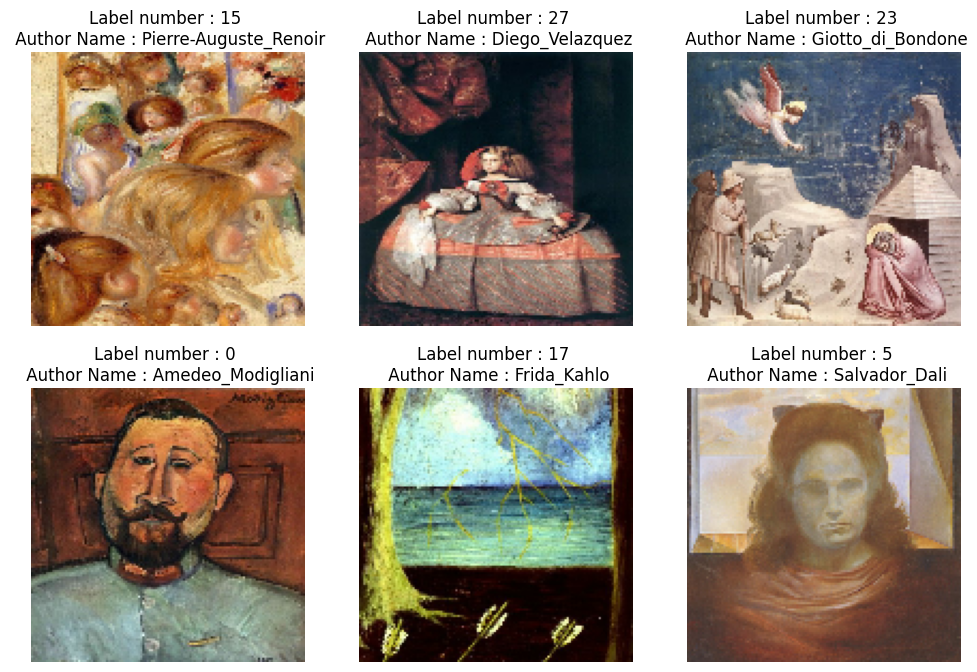

In [12]:
# 取出 Tensor 圖片來看看
plt.figure(figsize=(12, 8))
for index, (img, label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2, 3, index + 1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(l, rev_class_name[l]))
    plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [13]:
# 切割成 training data 與 validation data
train_len = int(0.8 * total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ", train_len, " val size : ", val_len)

# 添加 batch  #batch size的大小通常選擇在32-256之間
# todo
BATCH_SIZE =128  #每次訓練時會使用128筆資料進行梯度下降

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

train size :  6016  val size :  1504


In [14]:
# 查看添加batch後的維度
trainiter = iter(train_ds) #將 train_ds 資料集轉換成 iterator 物件，方便取出其中的資料。
x, y = trainiter.next()
print("training image batch shape : ", x.shape) #(batch_size, image_width, image_height, channels)
print("training label batch shape : ", y.shape) #(batch_size, num_classes)

training image batch shape :  (128, 128, 128, 3)
training label batch shape :  (128, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做 fine-tuning，**請自己手動建**。

In [15]:
input_shape = (128,128,3)
# 自訂你的 model
##########
# todo #
##########
model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                        

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [24]:
# todo
batch_size = 128
EPOCHS = 27

##########
# todo #
##########
# model.compile 決定 learning strategy、Loss calculator

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/27
47/47 [==============================] - 66s 1s/step - loss: 2.1994 - accuracy: 0.3973 - val_loss: 2.3305 - val_accuracy: 0.3830
Epoch 2/27
47/47 [==============================] - 43s 858ms/step - loss: 2.1387 - accuracy: 0.3974 - val_loss: 2.3325 - val_accuracy: 0.3763
Epoch 3/27
47/47 [==============================] - 42s 853ms/step - loss: 2.1198 - accuracy: 0.4067 - val_loss: 2.3274 - val_accuracy: 0.3810
Epoch 4/27
47/47 [==============================] - 42s 851ms/step - loss: 2.1074 - accuracy: 0.4121 - val_loss: 2.3288 - val_accuracy: 0.3850
Epoch 5/27
47/47 [==============================] - 42s 856ms/step - loss: 2.0794 - accuracy: 0.4162 - val_loss: 2.2772 - val_accuracy: 0.3963
Epoch 6/27
47/47 [==============================] - 42s 850ms/step - loss: 2.0494 - accuracy: 0.4262 - val_loss: 2.2954 - val_accuracy: 0.3910
Epoch 7/27
47/47 [==============================] - 44s 860ms/step - loss: 2.0393 - accuracy: 0.4299 - val_loss: 2.2657 - val_accuracy: 0.3883
Ep

## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


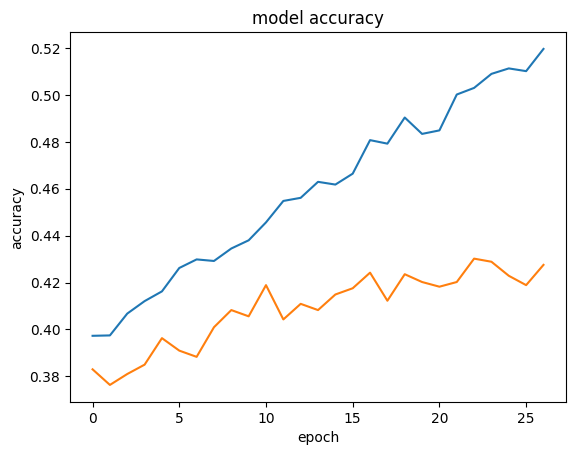

In [25]:
print(history.history.keys())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

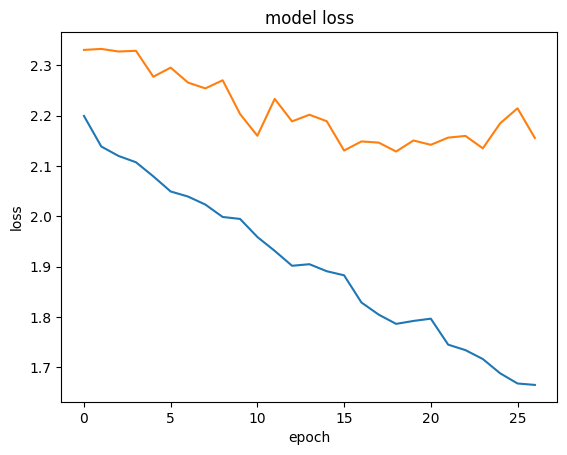

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.show()

In [27]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(BATCH_SIZE)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

7/7 [==============================] - 2s 25ms/step - loss: 2.1921 - accuracy: 0.4323
Test loss: 2.1921138763427734
Test accuracy: 0.4323353171348572


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入 Model 做預測

In [28]:
def predict_author(img):
    # 寫個單圖片模型預測 function
    # input : opencv img (height,width,3)
    # output : 某個作家名字 E.g. Claude_Monet
    #
    # 參考步驟:
    # 1. expand img dimension (height,width,3) -> (1,height,width,3)
    # 2. 丟入模型 model.predict
    # 3. 取出 softmax 後 (50,) 取最大值的 index 作為辨識結果
    # 4. 將辨識結果轉為畫作家名字

    author_name = ""
    ##########
    # todo #
    ##########
    
    # expand img dimension (height,width,3) -> (1,height,width,3)
    img = np.expand_dims(img, 0)
    # 丟入模型 model.predict
    predictions = model.predict(img)
    # 取出 softmax 後 (50,) 取最大值的 index 作為辨識結果
    predicted_index = np.argmax(predictions[0])

    # 將辨識結果轉為畫作家名字
    author_name = rev_class_name[predicted_index]
    return author_name

1/1 [==============================] - 0s 17ms/step


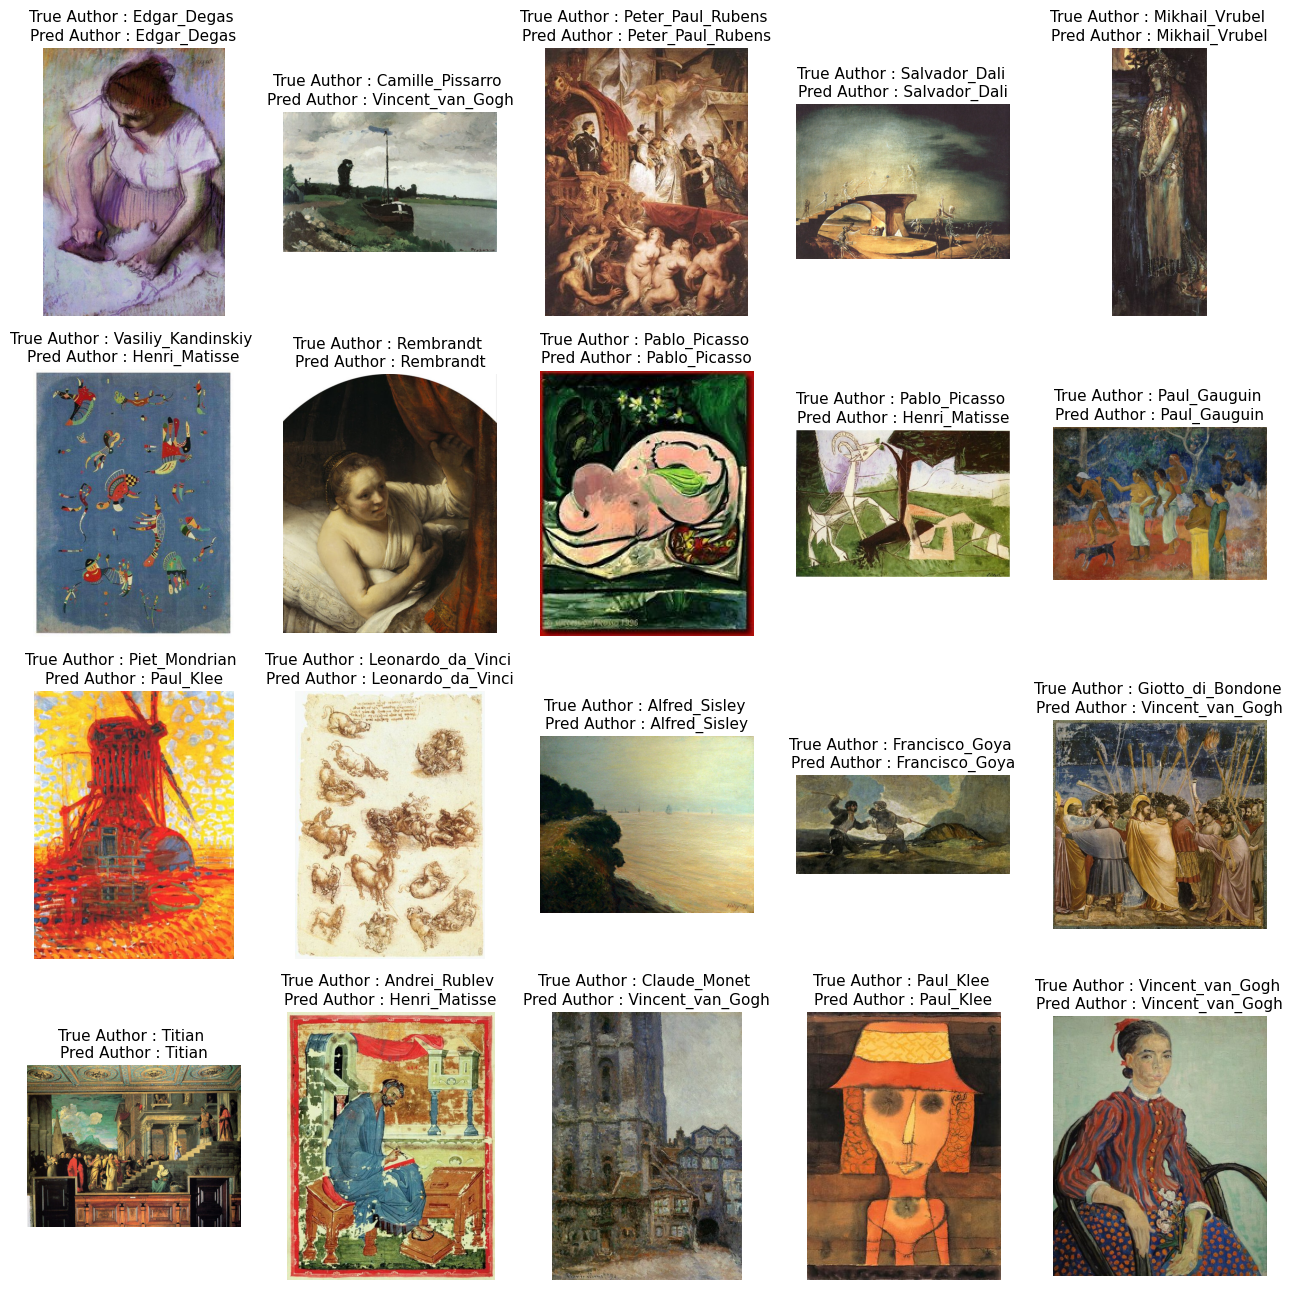

In [29]:
plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.axis("off")
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    plt.title(
        "True Author : {} \nPred Author : {}".format(
            "_".join(imgName.split("_")[:-1]), predict_author(img)
        ),
        size=11,
    )

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [30]:
from google.colab import files


def upload_img():
    uploaded = files.upload()
    img_name = list(uploaded.keys())[0]
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img


def eval():
    img = upload_img()
    plt.title("predict author : {}".format(predict_author(img)))
    plt.axis("off")
    plt.show()

Saving 測試照片.jpg to 測試照片 (1).jpg
1/1 [==============================] - 0s 19ms/step


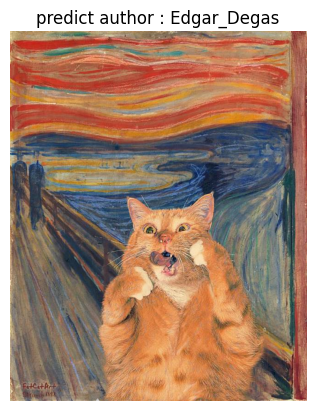

In [31]:
# 自己上傳一張圖片來試試看
# Demo 圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()